In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt


In [2]:
### use command line to
### retrieve a list of all CUMTD txt files and 
### save the list as a text file named cumtd_allfiles.txt at the directory "~/work"

### if open this notebook on server, use this line:
#!ls ~/work/data-readonly/CUMTD/ > ~/work/cumtd_allfiles.txt

### if open this notebook locally, read from your local files, for example:
!ls ./google_transit > ./cumtd_allfiles.txt

### retrieve file_allfiles.txt
file_list = pd.read_csv('cumtd_allfiles.txt', header = None)

### convert the pandas Series to an actual python list, the elements of which are strings
file_list = file_list[0].tolist()

### see what's in this file_list?
for file in file_list:
    print(file)

agency.txt
calendar.txt
calendar_dates.txt
fare_attributes.txt
fare_rules.txt
routes.txt
shapes.txt
stop_times.txt
stops.txt
trips.txt


In [3]:
# now iteratively read in all the CUMTD txt files

# save all the data in a dictionary named 'data', 
# each entry of the dict is a pandas DataFrame
data = {}

for file in file_list:
    data[file.replace(".txt","")] = pd.read_csv('~/google_transit/' + file)

In [4]:
data.keys()

dict_keys(['fare_rules', 'routes', 'stops', 'shapes', 'fare_attributes', 'trips', 'agency', 'calendar_dates', 'calendar', 'stop_times'])

In [5]:
data["stops"]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,KBYWSFLD:3,MTD4346,Kirby & Westfield (South Side),NaN,40.098248,-88.290173,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN
1,PHILOMI:4,MTD1026,Philo & Michigan (NW Corner),NaN,40.101792,-88.190865,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN
2,DNCNCLKRD:2,MTD3333,Duncan & Clark (SE Corner),NaN,40.117390,-88.295470,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN
3,TRLSPHILO:1,MTD6424,Trails & Philo (NE Corner),NaN,40.077915,-88.190315,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN
4,RMNERKA:4,MTD4040,Romine & Eureka (NW Corner),NaN,40.125585,-88.227525,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN
5,IRNWDSTLY:4,MTD0429,Ironwood & Staley (NW Corner),NaN,40.089826,-88.314226,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN
6,5THCLMBA:4,MTD2036,Fifth & Columbia (NW Corner),NaN,40.121308,-88.232153,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN
7,KRBYGLNSHR:1,MTD9073,Kirby & Glenshire (NE Corner),NaN,40.098683,-88.311765,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN
8,WDSRMTRY:3,MTD2774,Windsor & Monterey (SW Corner),NaN,40.083500,-88.253890,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN
9,GC:2,MTD2437,Ginger Creek (North Side),NaN,40.113025,-88.292158,1,http://www.cumtd.com/maps-and-schedules/bus-st...,0,NaN


# 1.Overall
## Scatterplot

In [6]:
def get_stop_latlon(stop):
    match = data['stops']['stop_id'] == stop
    stop_lat = data['stops'][match]['stop_lat'].values[0]
    stop_lon = data['stops'][match]['stop_lon'].values[0]
    return stop_lon, stop_lat

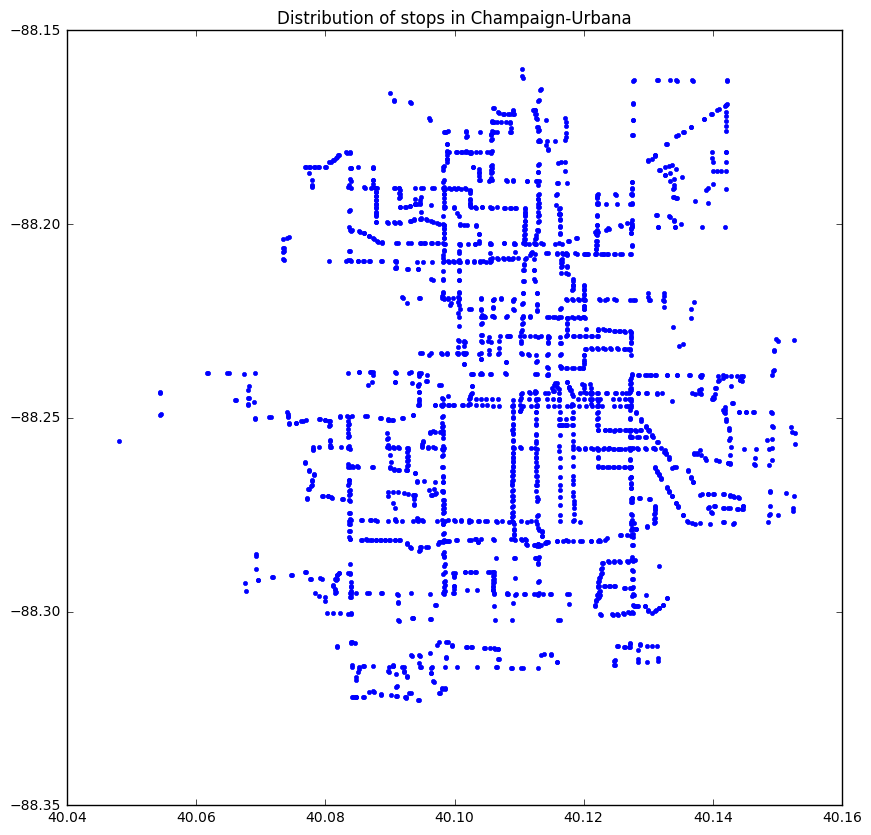

In [7]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(data["stops"]["stop_lat"],data["stops"]["stop_lon"],".")
plt.title("Distribution of stops in Champaign-Urbana")
plt.show()

## Plot in Google map (Both scatter plot and heatmap)
    The plot will be in the "scatter.html" and "heatmap.html"
    ???Shall we show the pic here? (Maybe use some technique that could capture screenshot from web?)

In [8]:
import gmplot
gmap = gmplot.GoogleMapPlotter(40.088, -88.281, 16)
gmap.heatmap(data["stops"]["stop_lat"], data["stops"]["stop_lon"])
gmap.draw("heatmap.html")

In [9]:
import gmplot
gmap = gmplot.GoogleMapPlotter(40.088, -88.281, 16)
gmap.scatter(data["stops"]["stop_lat"], data["stops"]["stop_lon"],'ee6481', size=40, marker=False)
gmap.draw("scatter.html")
#try iframe

## Density plot

/Users/beibri/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


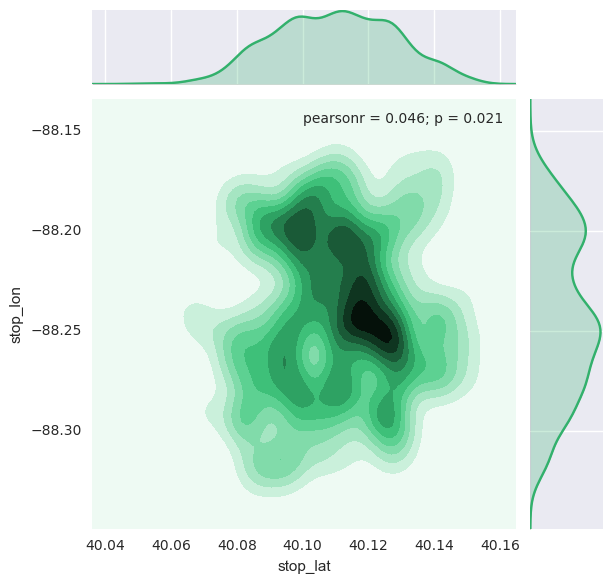

In [10]:
import seaborn as sns
stops=data["stops"]
ax=sns.jointplot(x="stop_lat",y='stop_lon',data=stops,kind="kde", color="#32b16c")

In [11]:
class Dataset:
    def __init__(self, data):
        self.data = data
        
    def convert(self, column, dtype):
        self.data[column] = np.array(self.data[column], dtype=dtype)
        
    def stats(self):
        statistics = {}
        for key in self.data:
            if self.data[key].dtype not in ("float", "int"):
                continue
            values = self.data[key]
            statistics[key] = (values.min(), values.max(), values.std(), values.mean())
        return statistics
    
    def filter_eq(self, column, value):
        good = (self.data[column] == value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def filter_lt(self, column, value):
        good = (self.data[column] < value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def filter_gt(self, column, value):
        good = (self.data[column] > value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def size(self):
        for key in self.data:
            return self.data[key].size
    
dataset = Dataset(data["stops"])


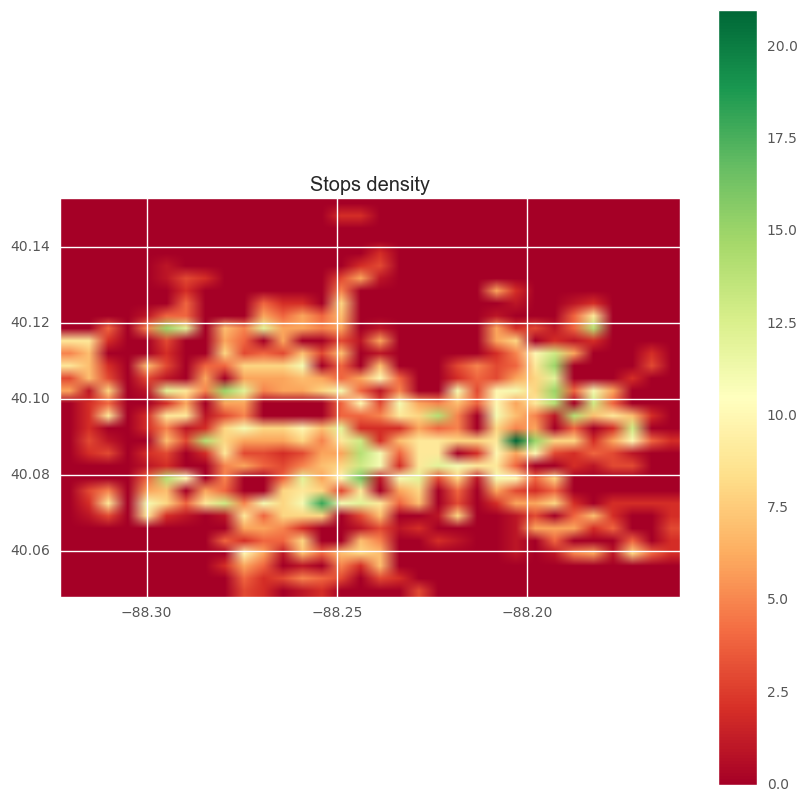

In [28]:
plt.rcParams["figure.figsize"] = (10, 10)
stats=dataset.stats()
lon_min=stats["stop_lon"][0]
lon_max=stats["stop_lon"][1]
lat_min=stats["stop_lat"][0]
lat_max=stats["stop_lat"][1]
num_bins=32
lon=np.mgrid[lon_min:lon_max:(num_bins+1)*1j]
lat=np.mgrid[lat_min:lat_max:(num_bins+1)*1j]
stops_count=np.zeros((num_bins,num_bins))
for i in range(num_bins):
    left_lat=lat[i]
    right_lat=lat[i+1]
    filter_lat_left=dataset.filter_gt("stop_lat",left_lat)
    filter_lat_right=filter_lat_left.filter_lt("stop_lat",right_lat)
    for j in range(num_bins):
        left_lon=lon[j]
        right_lon=lon[j+1]
        filter_lon_left=filter_lat_right.filter_gt("stop_lon",left_lon)
        filter_lon_right=filter_lon_left.filter_lt("stop_lon",right_lon)
        stops_count[i,j]+=filter_lon_right.size()
        
plt.imshow(stops_count,extent=(lon_min,lon_max,lat_min,lat_max),cmap=plt.cm.RdYlGn)
plt.title("Stops density")
color_bar=plt.colorbar()
#resolution
#latlon
#side by side
#in accordance with the seaborn one

⬆️ have no idea why the resolution is so low.....
will figure out

# 2. Choose top 10 stops that is busiest (in most trips)

In [13]:
from collections import Counter
stopid=data["stop_times"]["stop_id"]
word_counts = dict(Counter(stopid))
top_ten=dict(Counter(word_counts).most_common(10))
top_ten_keys=top_ten.keys()

In [14]:
top_ten_keys

dict_keys(['ARYWRT:3', 'IU:1', 'PAR:2', 'LSE:8', 'GRNMAT:3', 'IU:2', 'IT:5', 'PLAZA:4', 'GRNMAT:1', 'WRTCHAL:4'])

In [15]:
top_ten_sorted = sorted(top_ten.items(), key=lambda x: x[1],reverse=True)
print (top_ten_sorted)

[('PAR:2', 1732), ('IU:1', 1674), ('GRNMAT:3', 1660), ('IU:2', 1629), ('GRNMAT:1', 1617), ('ARYWRT:3', 1451), ('IT:5', 1317), ('PLAZA:4', 1292), ('LSE:8', 1286), ('WRTCHAL:4', 1247)]


In [16]:
stops=data["stops"]
top10data=stops.loc[stops['stop_id'].isin(top_ten_keys)]

In [17]:
def sort_list(top_ten_sorted):
    sortlist=[]
    for t in top_ten_sorted:
        t0=t[0]
        sortlist.append(t0)
    return sortlist

In [18]:
sortlist=sort_list(top_ten_sorted)

In [19]:
def get_stop_name(stop):
    match = data['stops']['stop_id'] == stop
    stop_name = data['stops'][match]['stop_name'].values[0]
    return stop_name

In [20]:
stoplist=[]
def stop_name_list(top_ten_keys):
    for i in top_ten_keys:
        selected=get_stop_name(i)
        stoplist.append(selected)
    return stoplist

In [21]:
sortname=stop_name_list(sortlist)
print (sortname)

['PAR (North Side Shelter)', 'Illini Union (South Side Shelter)', 'Green & Mathews (SW Corner)', 'Illini Union (Engineering Side)', 'Green & Mathews (NE Corner)', 'Armory & Wright (South Side)', 'Illinois Terminal (Platform C)', 'Transit Plaza (SE Platform)', 'Lincoln Square Garage South', 'Wright & Chalmers (NW Corner)']


## Bar Plot

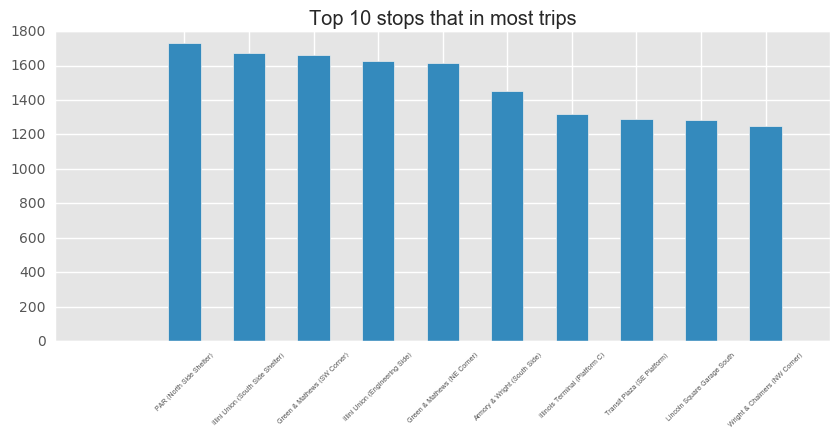

In [22]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.style.use("ggplot")
plt.bar(range(len(top_ten)), [t[1] for t in top_ten_sorted], align='center',width=0.5)
plt.xticks(range(len(top_ten)), sortname,fontsize=5,rotation='45')
plt.title("Top 10 stops that in most trips")

## Shows the top 10 popular stops in the scatterplot

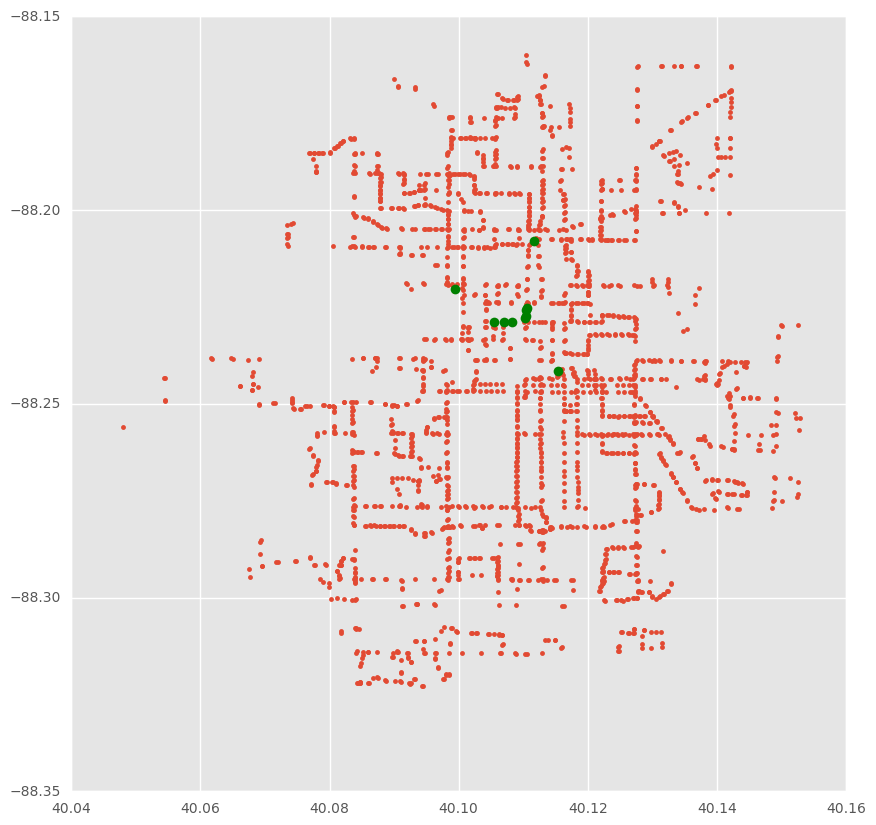

In [23]:
plt.rcParams["figure.figsize"] = (10, 10)
fig=plt.figure()
ax1=fig.add_subplot(111)
#legend
ax1.plot(data["stops"]["stop_lat"],data["stops"]["stop_lon"],".")
ax1.plot(top10data["stop_lat"],top10data["stop_lon"],"go")

## Then Annotate the most popular stop

In [24]:
top_one=dict(Counter(word_counts).most_common(1))
stop_name=get_stop_name("PAR:2")
lon=get_stop_latlon("PAR:2")
lon

(-88.220416, 40.09949000000001)

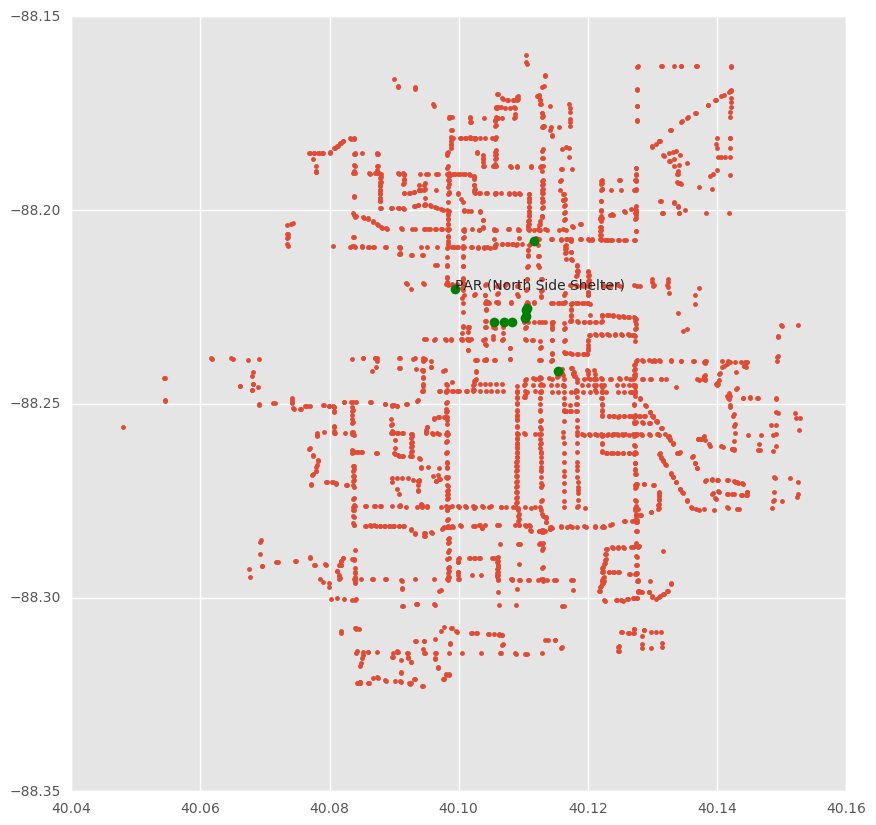

In [25]:
plt.rcParams["figure.figsize"] = (10, 10)
fig=plt.figure()
ax1=fig.add_subplot(111)
#legend
ax1.plot(data["stops"]["stop_lat"],data["stops"]["stop_lon"],".")
ax1.plot(top10data["stop_lat"],top10data["stop_lon"],"go")
ax1.annotate("PAR (North Side Shelter)",
            xy=(40.09949000000001,-88.220416), xycoords='data')
#circle the middle area
#zoom in the stops
